In [6]:
import numpy as np
import os, random
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, callbacks, Model
from sklearn.model_selection import TimeSeriesSplit
from feature_engineering import engineer_features
from data_loader import load_all_data
from sentiment import add_vader_sentiment, aggregate_daily_sentiment
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime, timedelta


SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
class AdvancedBitcoinPredictor:
    def __init__(self, sequence_length=60, prediction_horizon=30, prune_gb=True, ridge_alpha=1.0):
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.prune_gb = prune_gb
        self.ridge_alpha = ridge_alpha
        self.models = {}
        self.meta_model = None
        self.dir_model = None
        self.scaler = None
        self.regime_scaler = None
        self.feature_groups = {
            'price_volume': ['open', 'high', 'low', 'close', 'volume', 'high_close_ratio',
                             'low_close_ratio', 'open_close_ratio', 'volume_avg_ratio', 'volume_change'],
            'returns_momentum': ['returns_1d', 'returns_3d', 'returns_7d', 'log_returns',
                                 'momentum_5', 'momentum_10'],
            'technical': ['ma_5', 'price_ma_5_ratio', 'ma_10', 'price_ma_10_ratio', 'ma_20',
                          'price_ma_20_ratio', 'ema_12', 'ema_26', 'macd', 'macd_signal',
                          'macd_normalized', 'macd_signal_normalized', 'rsi', 'rsi_normalized'],
            'volatility': ['bb_middle', 'bb_upper', 'bb_lower', 'bb_position', 'bb_width',
                           'volatility_10', 'volatility_20'],
            'sentiment': ['avg_vader_compound', 'article_count', 'vader_ma_3', 'vader_ma_7',
                          'article_count_norm'],
            'funding': ['funding_rate', 'funding_rate_ma'],
            'temporal': ['day_sin', 'day_cos']
        }
    
    def _ensure_numeric_series(self, series, column_name):
        """Safely convert series to numeric, handling mixed types"""
        try:
            # Convert to numeric, coercing errors to NaN
            numeric_series = pd.to_numeric(series, errors='coerce')
            # Fill NaN with 0 for calculations
            return numeric_series.fillna(0)
        except Exception as e:
            print(f"Warning: Could not convert {column_name} to numeric: {e}")
            # Return a zero series of the same length
            return pd.Series([0.0] * len(series), index=series.index)
        
    def detect_market_regimes(self, df):
        """Detect market regimes using clustering on market conditions"""
        # Ensure consistent data types
        df = df.copy()
        
        # Features for regime detection
        regime_features = [
            'volatility_20', 'rsi', 'bb_position', 'returns_7d', 
            'volume_avg_ratio', 'funding_rate', 'avg_vader_compound'
        ]
        
        available_regime_features = [f for f in regime_features if f in df.columns]
        
        if len(available_regime_features) < 4:
            print("Warning: Not enough regime features available, using simple volatility-based regimes")
            return self._simple_volatility_regimes(df)
        
        # Ensure all regime features are numeric
        for feature in available_regime_features:
            df[feature] = self._ensure_numeric_series(df[feature], feature)
        
        # Scale regime features
        self.regime_scaler = RobustScaler()
        regime_data = self.regime_scaler.fit_transform(df[available_regime_features])
        
        # Use K-means to identify market regimes
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        regimes = kmeans.fit_predict(regime_data)
        
        # Assign regime labels based on characteristics
        regime_labels = []
        for i in range(4):
            regime_mask = regimes == i
            if regime_mask.sum() > 0:  # Check if any samples in this regime
                avg_vol = df.loc[regime_mask, 'volatility_20'].mean()
                avg_returns = df.loc[regime_mask, 'returns_7d'].mean()
                
                if avg_vol > df['volatility_20'].quantile(0.75):
                    if avg_returns > 0:
                        label = 'bull_volatile'
                    else:
                        label = 'bear_volatile'
                else:
                    if avg_returns > 0:
                        label = 'bull_stable'
                    else:
                        label = 'bear_stable'
            else:
                label = 'neutral'  # Default for empty regimes
            
            regime_labels.append(label)
        
        # Map regimes to labels
        regime_mapping = {i: regime_labels[i] for i in range(4)}
        labeled_regimes = [regime_mapping[r] for r in regimes]
        
        print(f"Detected regimes distribution:")
        unique, counts = np.unique(labeled_regimes, return_counts=True)
        for regime, count in zip(unique, counts):
            print(f"  {regime}: {count} days ({count/len(labeled_regimes)*100:.1f}%)")
        
        return labeled_regimes
    
    def _simple_volatility_regimes(self, df):
        """Simple volatility-based regime detection as fallback"""
        # Ensure numeric data
        volatility = self._ensure_numeric_series(df['volatility_20'], 'volatility_20')
        returns = self._ensure_numeric_series(df['returns_7d'], 'returns_7d')
        
        vol_25 = volatility.quantile(0.25)
        vol_75 = volatility.quantile(0.75)
        
        regimes = []
        for i in range(len(df)):
            vol = volatility.iloc[i]
            ret = returns.iloc[i]
            
            if vol > vol_75:
                regime = 'bull_volatile' if ret > 0 else 'bear_volatile'
            else:
                regime = 'bull_stable' if ret > 0 else 'bear_stable'
            
            regimes.append(regime)
        
        return regimes
    
    def detect_extreme_conditions(self, df):
        """Detect extreme market conditions for special handling - FIXED VERSION"""
        conditions = {}
        
        # Ensure all columns are numeric before operations
        volatility_20 = self._ensure_numeric_series(df['volatility_20'], 'volatility_20')
        returns_7d = self._ensure_numeric_series(df['returns_7d'], 'returns_7d')
        
        # Extreme volatility (top 10%)
        vol_threshold = volatility_20.quantile(0.90)
        conditions['extreme_vol'] = volatility_20 > vol_threshold
        
        # Extreme returns (beyond 2 standard deviations)
        ret_std = returns_7d.std()
        conditions['extreme_up'] = returns_7d > (2 * ret_std)
        conditions['extreme_down'] = returns_7d < (-2 * ret_std)
        
        # Extreme funding rates
        if 'funding_rate' in df.columns:
            funding_rate = self._ensure_numeric_series(df['funding_rate'], 'funding_rate')
            funding_std = funding_rate.std()
            conditions['extreme_funding'] = np.abs(funding_rate) > (2 * funding_std)
        else:
            conditions['extreme_funding'] = pd.Series([False] * len(df), index=df.index)
        
        # Extreme sentiment
        if 'avg_vader_compound' in df.columns:
            sentiment = self._ensure_numeric_series(df['avg_vader_compound'], 'avg_vader_compound')
            sent_std = sentiment.std()
            conditions['extreme_sentiment'] = np.abs(sentiment) > (2 * sent_std)
        else:
            conditions['extreme_sentiment'] = pd.Series([False] * len(df), index=df.index)
        
        # Combine all extreme conditions safely
        extreme_mask = (conditions['extreme_vol'] | 
                       conditions['extreme_up'] | 
                       conditions['extreme_down'] | 
                       conditions['extreme_funding'] | 
                       conditions['extreme_sentiment'])
        
        print(f"Extreme conditions detected in {extreme_mask.sum()} days ({extreme_mask.sum()/len(df)*100:.1f}%)")
        
        return extreme_mask, conditions
    
    def engineer_30day_target(self, df):
        """Engineer 30-day forward returns target with regime-aware adjustments - FIXED VERSION"""
        df_target = df.copy()
        
        # Ensure index is DatetimeIndex
        if not isinstance(df_target.index, pd.DatetimeIndex):
            df_target.index = pd.to_datetime(df_target.index)
        
        # Ensure close prices are numeric
        df_target['close'] = self._ensure_numeric_series(df_target['close'], 'close')
        
        # Basic 30-day return
        df_target['target_return_30d'] = (df_target['close'].shift(-self.prediction_horizon) - 
                                         df_target['close']) / df_target['close']
        
        # Regime-adjusted targets (optional - can help with regime-specific training)
        df_target['target_return_raw'] = df_target['target_return_30d'].copy()
        
        # Detect regimes and extreme conditions
        regimes = self.detect_market_regimes(df_target)
        extreme_mask, _ = self.detect_extreme_conditions(df_target)
        
        df_target['market_regime'] = regimes
        df_target['extreme_condition'] = extreme_mask
        
        # Optional: Apply regime-specific target smoothing for extreme conditions
        for regime in ['bull_volatile', 'bear_volatile']:
            # Create boolean mask safely
            regime_condition = pd.Series(regimes) == regime
            regime_mask = regime_condition & extreme_mask
            
            if regime_mask.sum() > 0:
                # Apply slight smoothing to extreme targets to prevent overfitting
                smoothed_values = (
                    df_target.loc[regime_mask, 'target_return_30d'] * 0.8 + 
                    df_target.loc[regime_mask, 'target_return_30d'].rolling(5, center=True).mean().fillna(0) * 0.2
                )
                df_target.loc[regime_mask, 'target_return_30d'] = smoothed_values
        
        df_target['target_direction_30d'] = (df_target['target_return_30d'] > 0).astype(int)
        df_target = df_target.dropna()
        
        return df_target
    
    def prepare_features(self, df):
        """Enhanced feature preparation with regime-aware scaling"""
        # Get all feature columns
        feature_cols = []
        for group_features in self.feature_groups.values():
            feature_cols.extend(group_features)
        
        available_features = [col for col in feature_cols if col in df.columns]
        
        # Ensure all feature columns are numeric
        for col in available_features:
            if col in df.columns:
                df[col] = self._ensure_numeric_series(df[col], col)
        
        # Add regime and extreme condition features
        if 'market_regime' in df.columns:
            # One-hot encode regimes
            regime_dummies = pd.get_dummies(df['market_regime'], prefix='regime')
            for col in regime_dummies.columns:
                df[col] = regime_dummies[col].astype(float)  # Ensure numeric
                available_features.append(col)
        
        if 'extreme_condition' in df.columns:
            df['extreme_condition'] = df['extreme_condition'].astype(float)  # Convert bool to float
            available_features.append('extreme_condition')
        
        # Add additional engineered features for extreme conditions
        additional_features = [col for col in df.columns if col not in available_features 
                             and col not in ['target_return_30d', 'target_direction_30d', 
                                           'target_return_raw', 'market_regime', 'next_close', 
                                           'target_return', 'target_direction']]
        
        # Ensure additional features are numeric
        for col in additional_features:
            if col in df.columns:
                df[col] = self._ensure_numeric_series(df[col], col)
        
        all_features = available_features + additional_features
        
        print(f"Using {len(all_features)} features for ensemble training")
        
        # Robust scaling with outlier handling
        self.scaler = RobustScaler(quantile_range=(5, 95))  # More aggressive outlier handling
        scaled_features = self.scaler.fit_transform(df[all_features])
        
        return scaled_features, all_features
    
    def build_cnn_lstm_model(self, input_shape, regime_specific=False):
        """Enhanced CNN-LSTM with attention and dropout for extreme conditions"""
        inputs = layers.Input(shape=input_shape)
        
        # Enhanced CNN branch with proper residual connections
        # First, project input to match CNN output dimensions
        input_projection = layers.Conv1D(filters=128, kernel_size=1, activation='linear', padding='same')(inputs)
        
        cnn_branch = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inputs)
        cnn_branch = layers.BatchNormalization()(cnn_branch)
        cnn_branch = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(cnn_branch)
        
        # Now we can add residual connection (both are 128 filters)
        cnn_residual = layers.Add()([input_projection, cnn_branch])
        
        cnn_branch = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(cnn_residual)
        cnn_branch = layers.BatchNormalization()(cnn_branch)
        cnn_branch = layers.MaxPooling1D(pool_size=2)(cnn_branch)
        cnn_branch = layers.Dropout(0.3)(cnn_branch)
        
        cnn_branch = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn_branch)
        cnn_branch = layers.GlobalMaxPooling1D()(cnn_branch)
        
        # Enhanced LSTM branch with bidirectional processing
        lstm_branch = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, 
                                                      recurrent_dropout=0.3))(inputs)
        lstm_branch = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3, 
                                                      recurrent_dropout=0.3))(lstm_branch)
        lstm_branch = layers.Bidirectional(layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3))(lstm_branch)
        
        # Multi-head attention mechanism
        attention = layers.Dense(64, activation='tanh')(lstm_branch)
        attention = layers.Dense(32, activation='tanh')(attention)
        attention = layers.Dense(1, activation='sigmoid')(attention)
        lstm_weighted = layers.multiply([lstm_branch, attention])
        
        # Combine features
        combined = layers.concatenate([cnn_branch, lstm_weighted])
        
        # Enhanced dense layers with adaptive dropout
        dense = layers.Dense(256, activation='relu')(combined)
        dense = layers.Dropout(0.4)(dense)
        dense = layers.Dense(128, activation='relu')(dense)
        dense = layers.Dropout(0.3)(dense)
        dense = layers.Dense(64, activation='relu')(dense)
        dense = layers.Dropout(0.2)(dense)
        
        # Output layer
        output = layers.Dense(1, activation='linear', name='return_prediction')(dense)
        
        model = Model(inputs=inputs, outputs=output)
        
        # Compile with Huber loss (more robust to outliers)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss=tf.keras.losses.Huber(delta=0.1),  # Robust to outliers
            metrics=['mae', 'mse']
        )
        
        return model
    
    def create_sequences(self, features, targets, regimes=None):
        """Create sequences with regime information"""
        X, y, regime_seq = [], [], []
        
        for i in range(len(features) - self.sequence_length - self.prediction_horizon + 1):
            X.append(features[i:(i + self.sequence_length)])
            y.append(targets[i + self.sequence_length])
            if regimes is not None:
                regime_seq.append(regimes[i + self.sequence_length])
        
        return np.array(X), np.array(y), regime_seq
    
    def train_ensemble(self, df, validation_split=0.2, epochs=150, batch_size=32):
        # Data type safety check at the beginning
        df = df.copy()
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
        
        df_proc = self.engineer_30day_target(df)
        features, _ = self.prepare_features(df_proc)
        targets = df_proc['target_return_30d'].values
        regimes = df_proc['market_regime'].values

        X, y, regime_seq = self.create_sequences(features, targets, regimes)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, shuffle=False)
        X_train_flat = X_train.reshape(len(X_train), -1)
        X_val_flat = X_val.reshape(len(X_val), -1)

        # Base models
        self.models['cnn_lstm'] = self.build_cnn_lstm_model((X.shape[1], X.shape[2]))
        es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        self.models['cnn_lstm'].fit(X_train, y_train, validation_data=(X_val, y_val),
                                    epochs=epochs, batch_size=batch_size,
                                    callbacks=[es, rl], verbose=1)

        self.models['random_forest'] = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
        self.models['random_forest'].fit(X_train_flat, y_train)

        if not self.prune_gb:
            self.models['gradient_boosting'] = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
            self.models['gradient_boosting'].fit(X_train_flat, y_train)

        # Stacking
        preds = []
        names = ['cnn_lstm', 'random_forest'] + (['gradient_boosting'] if not self.prune_gb else [])
        for name in names:
            if name == 'cnn_lstm':
                preds.append(self.models[name].predict(X_val).flatten())
            else:
                preds.append(self.models[name].predict(X_val_flat))
        stacked = np.vstack(preds).T  # shape (n_samples, n_models)

        # Ridge meta-learner with non-negative coefficients
        self.meta_model = Ridge(alpha=self.ridge_alpha, positive=True)
        self.meta_model.fit(stacked, y_val)
        print("Meta-learner coefs:", self.meta_model.coef_)
        return X_val, y_val, regime_seq

    def predict_ensemble(self, X):
        """Make ensemble predictions and also return individual model outputs and meta weights."""
        # Compute individual predictions
        individual_preds = {}
        X_flat = X.reshape(len(X), -1)
        names = ['cnn_lstm', 'random_forest'] + (['gradient_boosting'] if 'gradient_boosting' in self.models else [])
        for name in names:
            if name == 'cnn_lstm':
                pred = self.models[name].predict(X).flatten()
            else:
                pred = self.models[name].predict(X_flat)
            individual_preds[name] = pred

        # Stack for meta-model
        stacked = np.vstack([individual_preds[name] for name in names]).T
        ensemble = self.meta_model.predict(stacked)

        # Meta-model weights for interpretability
        weights = {'meta_coefs': self.meta_model.coef_}
        return ensemble.reshape(-1,1), individual_preds, weights

    def evaluate_ensemble(self, X_val, y_val, regime_seq_val=None):
        """Evaluate ensemble performance with provided validation set."""
        ensemble_pred, individual_preds, weights = self.predict_ensemble(X_val)

        # Calculate metrics
        mae = mean_absolute_error(y_val, ensemble_pred)
        mse = mean_squared_error(y_val, ensemble_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, ensemble_pred)
        direction_accuracy = np.mean(np.sign(y_val) == np.sign(ensemble_pred.flatten()))

        print(f"\n=== Ensemble Performance ===")
        print(f"MAE: {mae:.6f}")
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"R²: {r2:.6f}")
        print(f"Direction Accuracy: {direction_accuracy:.4f}")

        print(f"\n=== Individual Model Performance ===")
        for model_name, pred in individual_preds.items():
            model_mae = mean_absolute_error(y_val, pred)
            model_mse = mean_squared_error(y_val, pred)
            model_rmse = np.sqrt(mse)
            model_r2 = r2_score(y_val, pred)
            model_dir_acc = np.mean(np.sign(y_val) == np.sign(pred.flatten()))
            print(f"{model_name}: MAE={model_mae:.6f}, MSE={model_mse:.6f}, RMSE={model_rmse:.6f}, R²={model_r2:.6f}, Dir_Acc={model_dir_acc:.4f}")

        print(f"\nMeta-model weights: {weights['meta_coefs']}")
        return {
            'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2,
            'direction_accuracy': direction_accuracy,
            'individual_performance': individual_preds,
            'meta_weights': weights['meta_coefs']
        }

    def validate_meta_learner(self, df, n_splits=5, stratify=False, epochs=150, batch_size=32):
        """
        Perform rolling-window cross-validation to assess stability of meta-learner coefficients.
        Prints per-fold and mean coefficients for stacking meta-model.
        """
        # Data type safety check
        df = df.copy()
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
            
        # Prepare processed data
        df_proc = self.engineer_30day_target(df)
        features, _ = self.prepare_features(df_proc)
        targets = df_proc['target_return_30d'].values
        regimes = df_proc['market_regime'].values
        X, y, regime_seq = self.create_sequences(features, targets, regimes)

        # Select splitter
        if stratify:
            splitter = StratifiedKFold(n_splits=n_splits, shuffle=False)
            split_fn = lambda: splitter.split(X, regime_seq)
        else:
            splitter = TimeSeriesSplit(n_splits=n_splits)
            split_fn = lambda: splitter.split(X)

        coefs = []
        for fold, (train_idx, val_idx) in enumerate(split_fn()):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            X_train_flat = X_train.reshape(len(X_train), -1)
            X_val_flat = X_val.reshape(len(X_val), -1)

            # Retrain base models
            m1 = self.build_cnn_lstm_model((X.shape[1], X.shape[2]))
            m1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs,
                   batch_size=batch_size, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)], verbose=0)
            m2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
            m2.fit(X_train_flat, y_train)
            models = [m1, m2]
            if not self.prune_gb:
                m3 = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
                m3.fit(X_train_flat, y_train)
                models.append(m3)

            # Stack predictions
            preds = []
            for i, mdl in enumerate(models):
                if i == 0:
                    preds.append(mdl.predict(X_val).flatten())
                else:
                    preds.append(mdl.predict(X_val_flat))
            stacked = np.vstack(preds).T

            # Fit Ridge meta-model
            meta = Ridge(alpha=self.ridge_alpha, positive=True)
            meta.fit(stacked, y_val)
            print(f"Fold {fold+1} coefs: {meta.coef_}")
            coefs.append(meta.coef_)

        coefs = np.array(coefs)
        print("Mean coefs:", coefs.mean(axis=0), "Std dev:", coefs.std(axis=0))
        return coefs
            
    def build_direction_model(self, input_shape):
        """Build a Bidirectional LSTM for binary direction classification."""
        inp = layers.Input(shape=input_shape)
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(inp)
        x = layers.Bidirectional(layers.LSTM(32, dropout=0.2))(x)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        out = layers.Dense(1, activation='sigmoid', name='direction')(x)
        model = Model(inputs=inp, outputs=out)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

    def train_direction_classifier(self, df, validation_split=0.2, epochs=50, batch_size=32):
        """Train the direction classifier using 30-day direction labels."""
        # Data type safety check
        df = df.copy()
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
            
        df_proc = self.engineer_30day_target(df)
        features, _ = self.prepare_features(df_proc)
        targets = df_proc['target_direction_30d'].values
        X, y, _ = self.create_sequences(features, targets)

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, shuffle=False)

        self.dir_model = self.build_direction_model((X.shape[1], X.shape[2]))
        es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
        history = self.dir_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[es, rl],
            verbose=1
        )
        return history, X_val, y_val

    def predict_direction(self, X):
        """Predict direction probabilities (0–1) with the trained classifier."""
        if self.dir_model is None:
            raise ValueError("Direction model not trained. Call train_direction_classifier first.")
        return self.dir_model.predict(X, verbose=0).flatten()

    def predict_next_30d(self, df, threshold=0.5):
        """Predict next 30-day direction & return, gating regression by classifier."""
        # Data type safety check
        df = df.copy()
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
            
        # Prepare regression inputs
        features, _ = self.prepare_features(df)
        seq = features[-self.sequence_length:].reshape(1, self.sequence_length, -1)

        # Get direction probability
        dir_prob = self.predict_direction(seq)

        # Get regression prediction
        reg_pred, _, _ = self.predict_ensemble(seq)
        ret_pred = reg_pred[0][0]

        # Gate output based on direction confidence
        direction = 1 if dir_prob >= threshold else 0
        gated_return = ret_pred if direction == 1 else -ret_pred

        return {'direction_prob': dir_prob[0],
                'predicted_direction': direction,
                'predicted_return': gated_return}
    
    def evaluate_direction_classifier(self, X_val, y_val):
        """
        Evaluate the trained direction classifier on validation data.
        Computes accuracy, precision, recall, F1-score, and returns a report.
        """
        if self.dir_model is None:
            raise ValueError("Direction model not trained. Call train_direction_classifier first.")
        # Predict probabilities and labels
        probs = self.dir_model.predict(X_val, verbose=0).flatten()
        preds = (probs >= 0.5).astype(int)

        # Compute metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
        acc = accuracy_score(y_val, preds)
        prec = precision_score(y_val, preds)
        rec = recall_score(y_val, preds)
        f1 = f1_score(y_val, preds)
        auc = roc_auc_score(y_val, probs)
        cm = confusion_matrix(y_val, preds)

        # Print report
        print("=== Direction Classifier Evaluation ===")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"ROC AUC: {auc:.4f}")
        print("Confusion Matrix:")
        print(cm)

        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'roc_auc': auc,
            'confusion_matrix': cm
        }
    
    def train_and_evaluate_consistently(self, df, validation_split=0.2, epochs=150, batch_size=32):
        """
        Train both ensemble and direction classifier on the same data splits
        for consistent evaluation and comparison.
        """
        # Data type safety check
        df = df.copy()
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
        
        # Single data preparation
        df_proc = self.engineer_30day_target(df)
        features, feature_names = self.prepare_features(df_proc)
        
        # Get both targets
        return_targets = df_proc['target_return_30d'].values
        direction_targets = df_proc['target_direction_30d'].values
        regimes = df_proc['market_regime'].values
        
        # Create sequences for both tasks
        X_return, y_return, regime_seq = self.create_sequences(features, return_targets, regimes)
        X_direction, y_direction, _ = self.create_sequences(features, direction_targets, regimes)
        
        # Use the SAME split for both tasks
        train_size = int(len(X_return) * (1 - validation_split))
        
        # Split data consistently
        X_train = X_return[:train_size]
        X_val = X_return[train_size:]
        y_return_train = y_return[:train_size]
        y_return_val = y_return[train_size:]
        y_direction_train = y_direction[:train_size]
        y_direction_val = y_direction[train_size:]
        regime_seq_train = regime_seq[:train_size]
        regime_seq_val = regime_seq[train_size:]
        
        print(f"Training on {len(X_train)} samples, validating on {len(X_val)} samples")
        
        # Train ensemble (regression)
        X_train_flat = X_train.reshape(len(X_train), -1)
        X_val_flat = X_val.reshape(len(X_val), -1)
        
        # Base models
        self.models['cnn_lstm'] = self.build_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))
        es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        
        print("Training CNN-LSTM...")
        self.models['cnn_lstm'].fit(X_train, y_return_train, 
                                validation_data=(X_val, y_return_val),
                                epochs=epochs, batch_size=batch_size,
                                callbacks=[es, rl], verbose=1)
        
        print("Training Random Forest...")
        self.models['random_forest'] = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
        self.models['random_forest'].fit(X_train_flat, y_return_train)
        
        if not self.prune_gb:
            print("Training Gradient Boosting...")
            self.models['gradient_boosting'] = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
            self.models['gradient_boosting'].fit(X_train_flat, y_return_train)
        
        # Train meta-learner
        preds = []
        names = ['cnn_lstm', 'random_forest'] + (['gradient_boosting'] if not self.prune_gb else [])
        for name in names:
            if name == 'cnn_lstm':
                preds.append(self.models[name].predict(X_val).flatten())
            else:
                preds.append(self.models[name].predict(X_val_flat))
        stacked = np.vstack(preds).T
        
        self.meta_model = Ridge(alpha=self.ridge_alpha, positive=True)
        self.meta_model.fit(stacked, y_return_val)
        print("Meta-learner coefficients:", self.meta_model.coef_)
        
        # Train direction classifier
        print("Training direction classifier...")
        self.dir_model = self.build_direction_model((X_train.shape[1], X_train.shape[2]))
        es_dir = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        rl_dir = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
        
        self.dir_model.fit(X_train, y_direction_train,
                        validation_data=(X_val, y_direction_val),
                        epochs=50, batch_size=batch_size,
                        callbacks=[es_dir, rl_dir], verbose=1)
        
        return X_val, y_return_val, y_direction_val, regime_seq_val

    def evaluate_both_consistently(self, X_val, y_return_val, y_direction_val, regime_seq_val=None):
        """
        Evaluate both ensemble and direction classifier on the same validation data
        for direct comparison.
        """
        # Get ensemble predictions
        ensemble_pred, individual_preds, weights = self.predict_ensemble(X_val)
        
        # Get direction classifier predictions
        direction_probs = self.predict_direction(X_val)
        direction_preds = (direction_probs >= 0.5).astype(int)
        
        # Evaluate regression ensemble
        mae = mean_absolute_error(y_return_val, ensemble_pred)
        mse = mean_squared_error(y_return_val, ensemble_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_return_val, ensemble_pred)
        
        # Direction accuracy from ensemble (regression → direction)
        ensemble_direction_accuracy = np.mean(np.sign(y_return_val) == np.sign(ensemble_pred.flatten()))
        
        # Direction classifier metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        dir_accuracy = accuracy_score(y_direction_val, direction_preds)
        dir_precision = precision_score(y_direction_val, direction_preds)
        dir_recall = recall_score(y_direction_val, direction_preds)
        dir_f1 = f1_score(y_direction_val, direction_preds)
        dir_auc = roc_auc_score(y_direction_val, direction_probs)
        
        print(f"\n=== CONSISTENT EVALUATION ON SAME VALIDATION SET ===")
        print(f"Validation set size: {len(X_val)} samples")
        print(f"Validation period: Last {len(X_val)} sequences")
        
        print(f"\n=== Ensemble (Regression) Performance ===")
        print(f"MAE: {mae:.6f}")
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"R²: {r2:.6f}")
        print(f"Direction Accuracy (from regression): {ensemble_direction_accuracy:.4f}")
        
        print(f"\n=== Direction Classifier Performance ===")
        print(f"Binary Classification Accuracy: {dir_accuracy:.4f}")
        print(f"Precision: {dir_precision:.4f}")
        print(f"Recall: {dir_recall:.4f}")
        print(f"F1-score: {dir_f1:.4f}")
        print(f"ROC AUC: {dir_auc:.4f}")
        
        print(f"\n=== COMPARISON ===")
        print(f"Ensemble direction accuracy: {ensemble_direction_accuracy:.4f}")
        print(f"Dedicated classifier accuracy: {dir_accuracy:.4f}")
        print(f"Improvement from dedicated classifier: {dir_accuracy - ensemble_direction_accuracy:.4f}")
        
        # Regime-specific analysis if available
        if regime_seq_val is not None:
            print(f"\n=== Regime-Specific Performance ===")
            for regime in np.unique(regime_seq_val):
                mask = np.array(regime_seq_val) == regime
                if mask.sum() > 0:
                    regime_ensemble_acc = np.mean(np.sign(y_return_val[mask]) == np.sign(ensemble_pred.flatten()[mask]))
                    regime_dir_acc = accuracy_score(y_direction_val[mask], direction_preds[mask])
                    print(f"{regime}: Ensemble={regime_ensemble_acc:.4f}, Classifier={regime_dir_acc:.4f}")
        
        return {
            'ensemble': {
                'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2,
                'direction_accuracy': ensemble_direction_accuracy
            },
            'direction_classifier': {
                'accuracy': dir_accuracy, 'precision': dir_precision, 
                'recall': dir_recall, 'f1': dir_f1, 'auc': dir_auc
            },
            'meta_weights': weights['meta_coefs']
        }

In [8]:
btc_ohlcv, daily_oi, daily_funding_rate, df_news = load_all_data()
# Assuming you have your df with engineered features
df_news = add_vader_sentiment(df_news)
df_newsdaily_sentiment = aggregate_daily_sentiment(df_news)

# 3. Feature engineering
df = engineer_features(btc_ohlcv, daily_oi, daily_funding_rate, df_newsdaily_sentiment)

# Initialize predictor
predictor = AdvancedBitcoinPredictor(sequence_length=60, prediction_horizon=30)

In [21]:
# Train ensemble
X_val, y_val, regime_seq = predictor.train_ensemble(df, epochs=150)
# Evaluate ensemble
metrics = predictor.evaluate_ensemble(X_val, y_val, regime_seq)

Detected regimes distribution:
  bear_stable: 800 days (71.9%)
  bull_stable: 312 days (28.1%)
Extreme conditions detected in 260 days (23.4%)
Using 53 features for ensemble training
Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - loss: 0.1357 - mae: 1.4053 - mse: 5.0790 - val_loss: 0.0075 - val_mae: 0.1166 - val_mse: 0.0206 - learning_rate: 5.0000e-04
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0298 - mae: 0.3434 - mse: 0.3246 - val_loss: 0.0073 - val_mae: 0.1137 - val_mse: 0.0218 - learning_rate: 5.0000e-04
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0220 - mae: 0.2660 - mse: 0.1476 - val_loss: 0.0078 - val_mae: 0.1191 - val_mse: 0.0232 - learning_rate: 5.0000e-04
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0170 - mae: 0.2144 - mse: 0.0817 - val_loss: 0.0076 - val_mae: 0.1174 - val_mse: 0.0226 - learning_rate: 5.0000e-04
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0160 - mae: 0.2049 - mse: 0.0750 - val_los

In [22]:
history, X_val, y_val = predictor.train_direction_classifier(df)
metrics = predictor.evaluate_direction_classifier(X_val, y_val)

Detected regimes distribution:
  bear_stable: 800 days (71.9%)
  bull_stable: 312 days (28.1%)
Extreme conditions detected in 260 days (23.4%)
Using 53 features for ensemble training
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5745 - loss: 0.6812 - val_accuracy: 0.5678 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7113 - loss: 0.6045 - val_accuracy: 0.5930 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7981 - loss: 0.4971 - val_accuracy: 0.6583 - val_loss: 0.6110 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8261 - loss: 0.4179 - val_accuracy: 0.6784 - val_loss: 0.5702 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8508 - loss: 0.3370 - val_accuracy: 0.5678 - val_loss: 0.7457 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy:

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime, timedelta
import warnings

class ModelStabilityTester:
    def __init__(self, predictor):
        self.predictor = predictor
        self.results = {}
        
    def temporal_stability_test(self, df, n_splits=5, test_size=60):
        """Test model performance across different time periods"""
        print("=== Temporal Stability Test ===")
        
        # Use time series split for walk-forward analysis
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        
        temporal_results = {
            'ensemble_mae': [],
            'ensemble_r2': [],
            'ensemble_dir_acc': [],
            'direction_accuracy': [],
            'direction_auc': [],
            'periods': []
        }
        
        for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
            print(f"\nFold {fold+1}/{n_splits}")
            
            train_data = df.iloc[train_idx]
            test_data = df.iloc[test_idx]
            
            # Store period info
            train_start = train_data.index[0]
            train_end = train_data.index[-1]
            test_start = test_data.index[0]
            test_end = test_data.index[-1]
            
            print(f"Train: {train_start} to {train_end}")
            print(f"Test: {test_start} to {test_end}")
            
            # Train models on this fold
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    X_val, y_val, regime_seq = self.predictor.train_ensemble(
                        train_data, validation_split=0.2, epochs=50, batch_size=32
                    )
                    
                    # Train direction classifier
                    _, X_val_dir, y_val_dir = self.predictor.train_direction_classifier(
                        train_data, validation_split=0.2, epochs=30, batch_size=32
                    )
                    
                    # Evaluate ensemble
                    ensemble_metrics = self.predictor.evaluate_ensemble(X_val, y_val)
                    temporal_results['ensemble_mae'].append(ensemble_metrics['mae'])
                    temporal_results['ensemble_r2'].append(ensemble_metrics['r2'])
                    temporal_results['ensemble_dir_acc'].append(ensemble_metrics['direction_accuracy'])
                    
                    # Evaluate direction classifier
                    dir_metrics = self.predictor.evaluate_direction_classifier(X_val_dir, y_val_dir)
                    temporal_results['direction_accuracy'].append(dir_metrics['accuracy'])
                    temporal_results['direction_auc'].append(dir_metrics['roc_auc'])
                    
                    temporal_results['periods'].append({
                        'train_start': train_start,
                        'train_end': train_end,
                        'test_start': test_start,
                        'test_end': test_end
                    })
                    
            except Exception as e:
                print(f"Error in fold {fold+1}: {e}")
                continue
        
        self.results['temporal'] = temporal_results
        self._analyze_temporal_stability()
        return temporal_results
    
    def regime_stability_test(self, df):
        """Test model performance across different market regimes"""
        print("\n=== Regime Stability Test ===")
        
        # First, process the data to get regimes
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                df_processed = self.predictor.engineer_30day_target(df)
                
                regime_results = {}
                unique_regimes = df_processed['market_regime'].unique()
                
                for regime in unique_regimes:
                    print(f"\nTesting regime: {regime}")
                    regime_data = df_processed[df_processed['market_regime'] == regime]
                    
                    if len(regime_data) < 200:  # Need minimum data
                        print(f"Insufficient data for {regime} ({len(regime_data)} samples)")
                        continue
                    
                    # Train and evaluate on this regime
                    try:
                        X_val, y_val, _ = self.predictor.train_ensemble(
                            regime_data, validation_split=0.2, epochs=30, batch_size=32
                        )
                        
                        metrics = self.predictor.evaluate_ensemble(X_val, y_val)
                        
                        regime_results[regime] = {
                            'mae': metrics['mae'],
                            'r2': metrics['r2'],
                            'direction_accuracy': metrics['direction_accuracy'],
                            'sample_size': len(regime_data)
                        }
                    except Exception as e:
                        print(f"Error testing {regime}: {e}")
                        continue
                
                self.results['regime'] = regime_results
                return regime_results
        except Exception as e:
            print(f"Error in regime stability test: {e}")
            return {}
    
    def bootstrap_stability_test(self, df, n_bootstrap=10, sample_size=0.8):
        """Test model stability using bootstrap resampling - FIXED VERSION"""
        print("\n=== Bootstrap Stability Test ===")
        
        bootstrap_results = {
            'ensemble_mae': [],
            'ensemble_r2': [],
            'ensemble_dir_acc': [],
            'direction_accuracy': [],
            'direction_auc': []
        }
        
        n_samples = max(int(len(df) * sample_size), 200)  # Ensure minimum sample size
        original_seed = np.random.get_state()
        
        successful_iterations = 0
        
        for i in range(n_bootstrap):
            print(f"\nBootstrap iteration {i+1}/{n_bootstrap}")
            
            try:
                # Set different seed for each iteration
                np.random.seed(42 + i)
                
                # Create bootstrap sample with proper index handling
                bootstrap_idx = np.random.choice(len(df), size=n_samples, replace=True)
                bootstrap_df = df.iloc[bootstrap_idx].copy()
                
                # Reset index and sort by time for proper sequence creation
                bootstrap_df = bootstrap_df.reset_index(drop=True)
                bootstrap_df.index = pd.date_range(start='2020-01-01', periods=len(bootstrap_df), freq='D')
                
                # Skip if not enough data
                if len(bootstrap_df) < 150:
                    print(f"Insufficient data in bootstrap sample: {len(bootstrap_df)}")
                    continue
                
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    
                    # Train ensemble
                    X_val, y_val, _ = self.predictor.train_ensemble(
                        bootstrap_df, validation_split=0.2, epochs=30, batch_size=32
                    )
                    
                    # Check if validation set is reasonable
                    if len(X_val) < 10:
                        print(f"Validation set too small: {len(X_val)}")
                        continue
                    
                    # Evaluate ensemble
                    ensemble_metrics = self.predictor.evaluate_ensemble(X_val, y_val)
                    
                    # Validate metrics before adding
                    if (not np.isnan(ensemble_metrics['mae']) and 
                        not np.isnan(ensemble_metrics['r2']) and 
                        not np.isnan(ensemble_metrics['direction_accuracy'])):
                        
                        bootstrap_results['ensemble_mae'].append(ensemble_metrics['mae'])
                        bootstrap_results['ensemble_r2'].append(ensemble_metrics['r2'])
                        bootstrap_results['ensemble_dir_acc'].append(ensemble_metrics['direction_accuracy'])
                        
                        # Train direction classifier
                        _, X_val_dir, y_val_dir = self.predictor.train_direction_classifier(
                            bootstrap_df, validation_split=0.2, epochs=20, batch_size=32
                        )
                        
                        # Check direction classifier validation set
                        if len(X_val_dir) >= 10:
                            dir_metrics = self.predictor.evaluate_direction_classifier(X_val_dir, y_val_dir)
                            
                            if (not np.isnan(dir_metrics['accuracy']) and 
                                not np.isnan(dir_metrics['roc_auc'])):
                                
                                bootstrap_results['direction_accuracy'].append(dir_metrics['accuracy'])
                                bootstrap_results['direction_auc'].append(dir_metrics['roc_auc'])
                                
                                successful_iterations += 1
                            else:
                                print(f"Invalid direction metrics in iteration {i+1}")
                        else:
                            print(f"Direction validation set too small: {len(X_val_dir)}")
                    else:
                        print(f"Invalid ensemble metrics in iteration {i+1}")
                
            except Exception as e:
                print(f"Error in bootstrap iteration {i+1}: {e}")
                continue
        
        # Restore original random state
        np.random.set_state(original_seed)
        
        print(f"\nSuccessful bootstrap iterations: {successful_iterations}/{n_bootstrap}")
        
        if successful_iterations < 2:
            print("WARNING: Too few successful bootstrap iterations for reliable statistics")
            return bootstrap_results
        
        self.results['bootstrap'] = bootstrap_results
        self._analyze_bootstrap_stability()
        return bootstrap_results
    
    def feature_importance_stability(self, df, n_iterations=5):
        """Test stability of feature importance across different training runs"""
        print("\n=== Feature Importance Stability Test ===")
        
        feature_importance_runs = []
        
        for i in range(n_iterations):
            print(f"\nIteration {i+1}/{n_iterations}")
            
            try:
                # Train model with different random seed
                np.random.seed(42 + i)
                tf.random.set_seed(42 + i)
                
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    
                    X_val, y_val, _ = self.predictor.train_ensemble(
                        df, validation_split=0.2, epochs=30, batch_size=32
                    )
                    
                    # Get feature importance from Random Forest
                    if 'random_forest' in self.predictor.models:
                        rf_model = self.predictor.models['random_forest']
                        feature_importance = rf_model.feature_importances_
                        feature_importance_runs.append(feature_importance)
                        
            except Exception as e:
                print(f"Error in feature importance iteration {i+1}: {e}")
                continue
        
        if feature_importance_runs:
            # Calculate stability metrics
            importance_array = np.array(feature_importance_runs)
            mean_importance = np.mean(importance_array, axis=0)
            std_importance = np.std(importance_array, axis=0)
            
            # Fixed coefficient of variation calculation
            cv_importance = np.divide(std_importance, mean_importance, 
                                    out=np.zeros_like(std_importance), 
                                    where=mean_importance!=0)
            
            # Get top features
            top_indices = np.argsort(mean_importance)[-20:][::-1]
            
            print("\nTop 20 Most Important Features (with stability):")
            for idx in top_indices:
                print(f"Feature {idx}: {mean_importance[idx]:.4f} ± {std_importance[idx]:.4f} (CV: {cv_importance[idx]:.2f})")
        
        self.results['feature_importance'] = {
            'mean': mean_importance,
            'std': std_importance,
            'cv': cv_importance
        }
        
        return feature_importance_runs
    
    def prediction_consistency_test(self, df, n_runs=5):
        """Test if predictions are consistent across multiple training runs"""
        print("\n=== Prediction Consistency Test ===")
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                # Prepare test data
                df_processed = self.predictor.engineer_30day_target(df)
                features, _ = self.predictor.prepare_features(df_processed)
                
                # Create sequences for the last 100 samples
                X_all, _, _ = self.predictor.create_sequences(features, df_processed['target_return_30d'].values)
                
                if len(X_all) < 100:
                    print(f"Not enough sequences for consistency test: {len(X_all)}")
                    return [], []
                
                X_test = X_all[-100:]
                
                predictions_ensemble = []
                predictions_direction = []
                
                for i in range(n_runs):
                    print(f"\nRun {i+1}/{n_runs}")
                    
                    try:
                        # Train models with different random seeds
                        tf.random.set_seed(i * 42)
                        np.random.seed(i * 42)
                        
                        self.predictor.train_ensemble(df[:-100], validation_split=0.2, epochs=30, batch_size=32)
                        self.predictor.train_direction_classifier(df[:-100], validation_split=0.2, epochs=20, batch_size=32)
                        
                        # Get predictions
                        ensemble_pred, _, _ = self.predictor.predict_ensemble(X_test)
                        direction_pred = self.predictor.predict_direction(X_test)
                        
                        predictions_ensemble.append(ensemble_pred.flatten())
                        predictions_direction.append(direction_pred)
                        
                    except Exception as e:
                        print(f"Error in consistency run {i+1}: {e}")
                        continue
                
                if len(predictions_ensemble) < 2:
                    print("Not enough successful runs for consistency analysis")
                    return [], []
                
                # Analyze consistency
                ensemble_array = np.array(predictions_ensemble)
                direction_array = np.array(predictions_direction)
                
                # Calculate standard deviation across runs for each prediction
                ensemble_std = np.std(ensemble_array, axis=0)
                direction_std = np.std(direction_array, axis=0)
                
                print(f"\nEnsemble prediction std: {np.mean(ensemble_std):.6f}")
                print(f"Direction prediction std: {np.mean(direction_std):.6f}")
                
                # Calculate correlation between runs
                if len(ensemble_array) > 1:
                    ensemble_corr = np.corrcoef(ensemble_array)
                    direction_corr = np.corrcoef(direction_array)
                    
                    ensemble_corr_mean = np.mean(ensemble_corr[np.triu_indices_from(ensemble_corr, k=1)])
                    direction_corr_mean = np.mean(direction_corr[np.triu_indices_from(direction_corr, k=1)])
                    
                    print(f"\nAverage correlation between ensemble runs: {ensemble_corr_mean:.4f}")
                    print(f"Average correlation between direction runs: {direction_corr_mean:.4f}")
                    
                    self.results['consistency'] = {
                        'ensemble_std': ensemble_std,
                        'direction_std': direction_std,
                        'ensemble_corr': ensemble_corr,
                        'direction_corr': direction_corr
                    }
                
                return predictions_ensemble, predictions_direction
                
        except Exception as e:
            print(f"Error in prediction consistency test: {e}")
            return [], []
    
    def _analyze_temporal_stability(self):
        """Analyze temporal stability results"""
        if 'temporal' not in self.results:
            return
            
        temporal = self.results['temporal']
        
        print("\n=== Temporal Stability Analysis ===")
        
        # Calculate coefficient of variation for each metric
        metrics = ['ensemble_mae', 'ensemble_r2', 'ensemble_dir_acc', 'direction_accuracy', 'direction_auc']
        
        for metric in metrics:
            if metric in temporal and temporal[metric]:
                values = temporal[metric]
                if len(values) > 0:
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    
                    # Fixed coefficient of variation calculation
                    cv = std_val / abs(mean_val) if abs(mean_val) > 1e-10 else 0
                    
                    print(f"\n{metric}:")
                    print(f"  Mean: {mean_val:.4f}")
                    print(f"  Std: {std_val:.4f}")
                    print(f"  CV: {cv:.4f}")
                    print(f"  Range: [{min(values):.4f}, {max(values):.4f}]")
    
    def _analyze_bootstrap_stability(self):
        """Analyze bootstrap stability results"""
        if 'bootstrap' not in self.results:
            return
            
        bootstrap = self.results['bootstrap']
        
        print("\n=== Bootstrap Stability Analysis ===")
        
        for metric, values in bootstrap.items():
            if values and len(values) > 0:
                # Filter out invalid values
                valid_values = [v for v in values if not np.isnan(v) and np.isfinite(v)]
                
                if len(valid_values) > 0:
                    mean_val = np.mean(valid_values)
                    std_val = np.std(valid_values)
                    ci_lower = np.percentile(valid_values, 2.5)
                    ci_upper = np.percentile(valid_values, 97.5)
                    
                    print(f"\n{metric}:")
                    print(f"  Mean: {mean_val:.4f}")
                    print(f"  Std: {std_val:.4f}")
                    print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
                    print(f"  Valid samples: {len(valid_values)}/{len(values)}")
                else:
                    print(f"\n{metric}: No valid values")
    
    def plot_stability_results(self):
        """Visualize stability test results"""
        try:
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            
            # Temporal stability
            if 'temporal' in self.results and self.results['temporal']:
                temporal = self.results['temporal']
                ax = axes[0, 0]
                
                metrics_to_plot = ['ensemble_dir_acc', 'direction_accuracy']
                for metric in metrics_to_plot:
                    if metric in temporal and temporal[metric]:
                        ax.plot(temporal[metric], marker='o', label=metric)
                
                ax.set_title('Temporal Stability')
                ax.set_xlabel('Time Period')
                ax.set_ylabel('Accuracy')
                ax.legend()
                ax.grid(True, alpha=0.3)
            else:
                axes[0, 0].text(0.5, 0.5, 'No temporal data', ha='center', va='center', transform=axes[0, 0].transAxes)
                axes[0, 0].set_title('Temporal Stability (No Data)')
            
            # Bootstrap distributions
            if 'bootstrap' in self.results and self.results['bootstrap'].get('direction_accuracy'):
                bootstrap = self.results['bootstrap']
                ax = axes[0, 1]
                
                valid_values = [v for v in bootstrap['direction_accuracy'] if not np.isnan(v)]
                if valid_values:
                    ax.hist(valid_values, bins=20, alpha=0.7, label='Direction Accuracy')
                    ax.axvline(np.mean(valid_values), color='red', linestyle='--', label='Mean')
                    ax.set_title('Bootstrap Distribution - Direction Accuracy')
                    ax.set_xlabel('Accuracy')
                    ax.set_ylabel('Frequency')
                    ax.legend()
                else:
                    ax.text(0.5, 0.5, 'No valid bootstrap data', ha='center', va='center', transform=ax.transAxes)
                    ax.set_title('Bootstrap Distribution (No Valid Data)')
            else:
                axes[0, 1].text(0.5, 0.5, 'No bootstrap data', ha='center', va='center', transform=axes[0, 1].transAxes)
                axes[0, 1].set_title('Bootstrap Distribution (No Data)')
            
            # Regime performance
            if 'regime' in self.results and self.results['regime']:
                regime_data = self.results['regime']
                ax = axes[1, 0]
                
                regimes = list(regime_data.keys())
                accuracies = [regime_data[r]['direction_accuracy'] for r in regimes]
                
                ax.bar(regimes, accuracies)
                ax.set_title('Performance by Market Regime')
                ax.set_xlabel('Regime')
                ax.set_ylabel('Direction Accuracy')
                ax.tick_params(axis='x', rotation=45)
            else:
                axes[1, 0].text(0.5, 0.5, 'No regime data', ha='center', va='center', transform=axes[1, 0].transAxes)
                axes[1, 0].set_title('Regime Performance (No Data)')
            
            # Prediction consistency
            if 'consistency' in self.results and self.results['consistency']:
                ax = axes[1, 1]
                consistency = self.results['consistency']
                
                if 'direction_corr' in consistency:
                    im = ax.imshow(consistency['direction_corr'], cmap='coolwarm', vmin=0, vmax=1)
                    ax.set_title('Direction Prediction Correlation Matrix')
                    ax.set_xlabel('Run')
                    ax.set_ylabel('Run')
                    plt.colorbar(im, ax=ax)
                else:
                    ax.text(0.5, 0.5, 'No correlation data', ha='center', va='center', transform=ax.transAxes)
                    ax.set_title('Prediction Consistency (No Data)')
            else:
                axes[1, 1].text(0.5, 0.5, 'No consistency data', ha='center', va='center', transform=axes[1, 1].transAxes)
                axes[1, 1].set_title('Prediction Consistency (No Data)')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error creating stability plots: {e}")
    
    def generate_stability_report(self):
        """Generate comprehensive stability report"""
        print("\n" + "="*60)
        print("COMPREHENSIVE STABILITY REPORT")
        print("="*60)
        
        # Overall stability score
        stability_scores = []
        
        # Temporal stability score
        if 'temporal' in self.results and self.results['temporal'].get('direction_accuracy'):
            temporal = self.results['temporal']
            dir_acc_values = [v for v in temporal['direction_accuracy'] if not np.isnan(v)]
            
            if len(dir_acc_values) > 1:
                mean_acc = np.mean(dir_acc_values)
                dir_acc_cv = np.std(dir_acc_values) / mean_acc if mean_acc > 0 else 0
                temporal_score = max(0, 1 - dir_acc_cv)
                stability_scores.append(('Temporal', temporal_score))
                print(f"\nTemporal Stability Score: {temporal_score:.2f}")
                print(f"  - Direction accuracy CV: {dir_acc_cv:.3f}")
            else:
                print(f"\nTemporal Stability Score: N/A (insufficient data)")
        
        # Bootstrap stability score
        if 'bootstrap' in self.results and self.results['bootstrap'].get('direction_accuracy'):
            bootstrap = self.results['bootstrap']
            dir_acc_values = [v for v in bootstrap['direction_accuracy'] if not np.isnan(v)]
            
            if len(dir_acc_values) > 1:
                dir_acc_std = np.std(dir_acc_values)
                bootstrap_score = max(0, 1 - dir_acc_std*10)
                stability_scores.append(('Bootstrap', bootstrap_score))
                print(f"\nBootstrap Stability Score: {bootstrap_score:.2f}")
                print(f"  - Direction accuracy std: {dir_acc_std:.4f}")
            else:
                print(f"\nBootstrap Stability Score: N/A (insufficient data)")
        
        # Consistency score
        if 'consistency' in self.results and self.results['consistency'].get('direction_corr') is not None:
            consistency = self.results['consistency']
            corr_matrix = consistency['direction_corr']
            
            if corr_matrix.size > 1:
                avg_corr = np.mean(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
                consistency_score = max(0, avg_corr)
                stability_scores.append(('Consistency', consistency_score))
                print(f"\nConsistency Score: {consistency_score:.2f}")
                print(f"  - Average correlation between runs: {avg_corr:.3f}")
            else:
                print(f"\nConsistency Score: N/A (insufficient data)")
        
        # Overall score
        if stability_scores:
            overall_score = np.mean([score for _, score in stability_scores])
            print(f"\n{'='*40}")
            print(f"OVERALL STABILITY SCORE: {overall_score:.2f}/1.00")
            print(f"{'='*40}")
            
            if overall_score > 0.8:
                print("✅ Model shows EXCELLENT stability")
            elif overall_score > 0.6:
                print("⚠️ Model shows MODERATE stability")
            else:
                print("❌ Model shows POOR stability - consider improvements")
        else:
            print(f"\n{'='*40}")
            print("OVERALL STABILITY SCORE: N/A")
            print("(Insufficient data for stability analysis)")
            print(f"{'='*40}")
        
        return stability_scores

=== Temporal Stability Test ===

Fold 1/5
Train: 2017-09-06 00:00:00 to 2024-09-15 00:00:00
Test: 2024-09-16 00:00:00 to 2024-11-14 00:00:00
Detected regimes distribution:
  bear_stable: 1544 days (60.1%)
  bear_volatile: 383 days (14.9%)
  bull_stable: 640 days (24.9%)
Extreme conditions detected in 361 days (14.1%)
Using 45 features for ensemble training
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 0.0886 - mae: 0.9333 - mse: 5.2004 - val_loss: 0.0081 - val_mae: 0.1214 - val_mse: 0.0255 - learning_rate: 5.0000e-04
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0210 - mae: 0.2550 - mse: 0.1249 - val_loss: 0.0076 - val_mae: 0.1158 - val_mse: 0.0246 - learning_rate: 5.0000e-04
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0185 - mae: 0.2295 - mse: 0.1050 - val_loss: 0.0081 - val_mae: 0.1209 - val_mse: 0.0276 - learning_rate: 5.0000e-04
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0164 - mae: 0.2085 - mse: 0.0827 - val_loss: 0.0

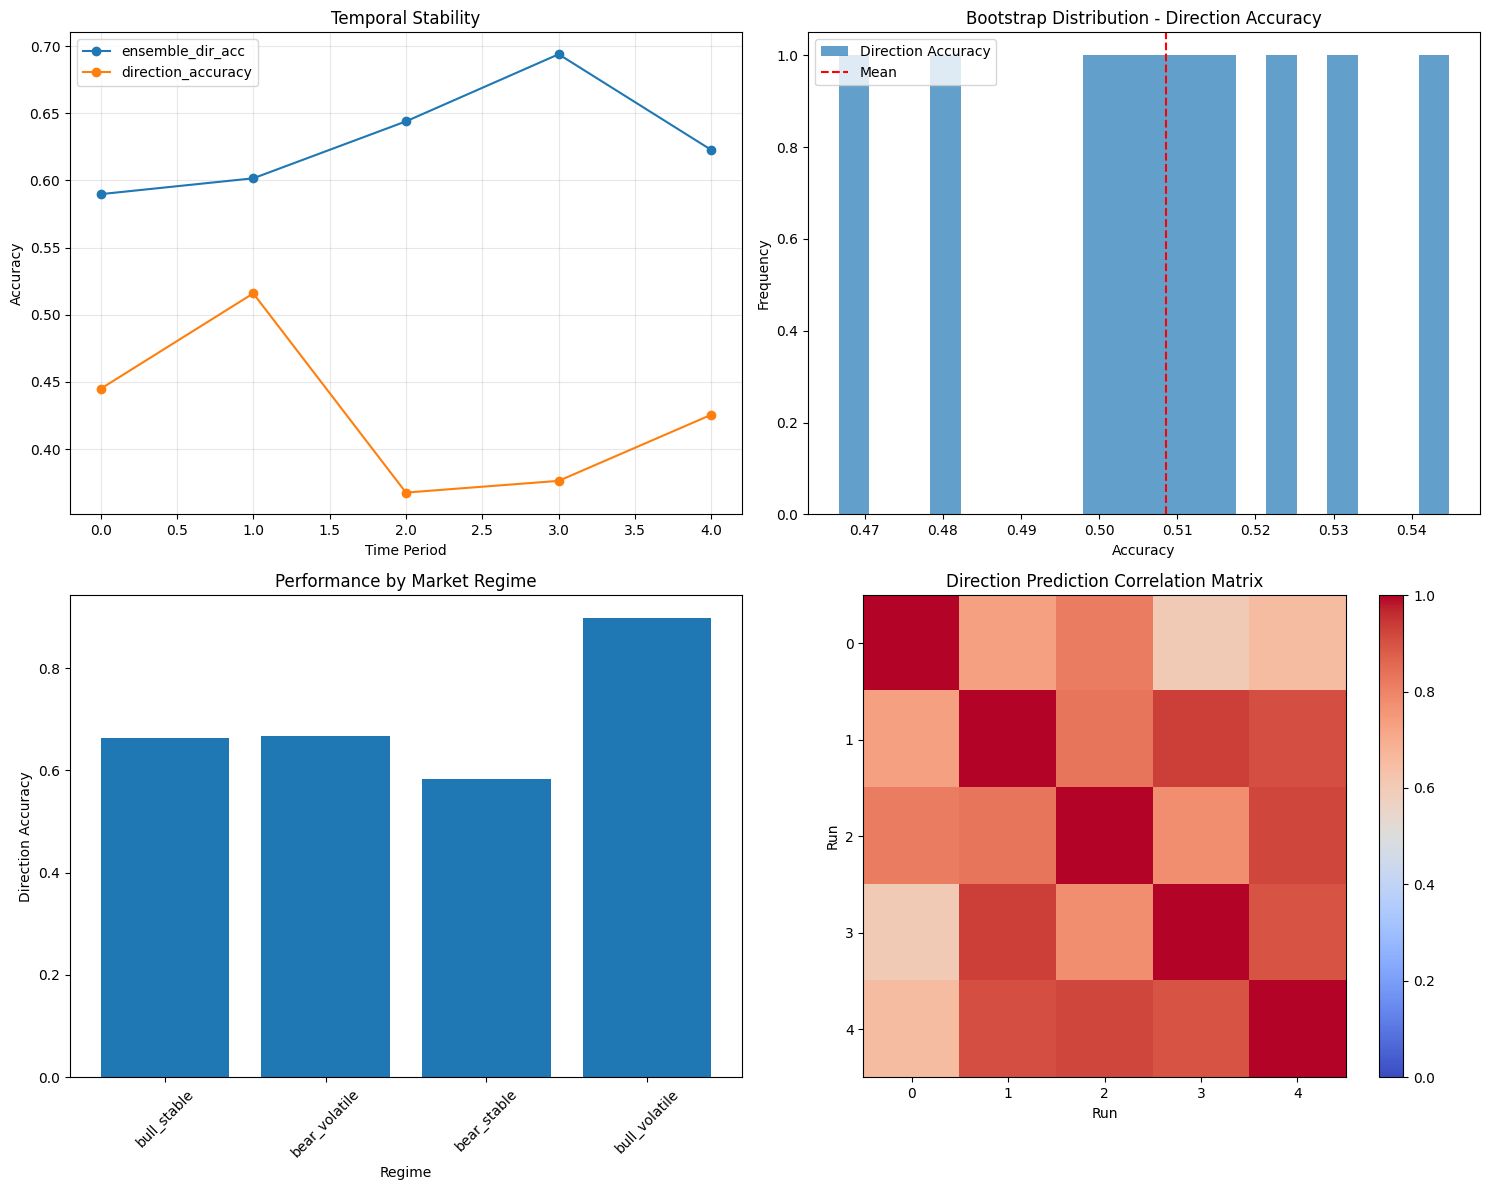


COMPREHENSIVE STABILITY REPORT

Temporal Stability Score: 0.87
  - Direction accuracy CV: 0.126

Bootstrap Stability Score: 0.78
  - Direction accuracy std: 0.0218

Consistency Score: 0.81
  - Average correlation between runs: 0.806

OVERALL STABILITY SCORE: 0.82/1.00
✅ Model shows EXCELLENT stability


[('Temporal', np.float64(0.8744913052924445)),
 ('Bootstrap', np.float64(0.7824456429550165)),
 ('Consistency', np.float64(0.8058123283769316))]

In [10]:
# Usage example:
tester = ModelStabilityTester(predictor)
tester.temporal_stability_test(df, n_splits=5)
tester.bootstrap_stability_test(df, n_bootstrap=10)
tester.regime_stability_test(df)
tester.prediction_consistency_test(df, n_runs=5)
tester.plot_stability_results()
tester.generate_stability_report()

In [ ]:
def backtest_hybrid(predictor, df, threshold=0.7, initial_capital=10000):
    """
    Backtest the hybrid model (ensemble + direction classifier) strategy
    """
    print("=== Hybrid Strategy Backtest ===")
    
    # Prepare data for backtesting
    df_processed = predictor.engineer_30day_target(df)
    features, _ = predictor.prepare_features(df_processed)
    
    # Create sequences
    X_all, y_all, _ = predictor.create_sequences(features, df_processed['target_return_30d'].values)
    
    # Use last 20% for backtesting
    test_size = int(len(X_all) * 0.2)
    X_test = X_all[-test_size:]
    y_test = y_all[-test_size:]
    
    # Get predictions
    try:
        ensemble_preds, _, _ = predictor.predict_ensemble(X_test)
        direction_probs = predictor.predict_direction(X_test)
        
        # Create backtest results
        results = []
        capital = initial_capital
        position = 0
        
        for i in range(len(X_test)):
            # Get prediction signals
            predicted_return = ensemble_preds[i][0]
            direction_prob = direction_probs[i]
            actual_return = y_test[i]
            
            # Trading signal based on threshold
            if direction_prob >= threshold:
                signal = 1  # Buy
            elif direction_prob <= (1 - threshold):
                signal = -1  # Sell
            else:
                signal = 0  # Hold
            
            # Calculate position size (simple 100% allocation)
            if signal != 0:
                position = signal
            
            # Calculate returns
            strategy_return = position * actual_return
            capital *= (1 + strategy_return)
            
            results.append({
                'predicted_return': predicted_return,
                'direction_prob': direction_prob,
                'actual_return': actual_return,
                'signal': signal,
                'position': position,
                'strategy_return': strategy_return,
                'capital': capital
            })
        
        results_df = pd.DataFrame(results)
        
        # Calculate performance metrics
        total_return = (capital - initial_capital) / initial_capital
        strategy_returns = results_df['strategy_return']
        
        # Basic performance metrics
        metrics = {
            'total_return': total_return,
            'annualized_return': total_return * (365/30),  # Assuming 30-day periods
            'volatility': strategy_returns.std() * np.sqrt(365/30),
            'sharpe_ratio': strategy_returns.mean() / strategy_returns.std() if strategy_returns.std() > 0 else 0,
            'max_drawdown': (results_df['capital'] / results_df['capital'].cummax() - 1).min(),
            'hit_rate': (strategy_returns > 0).mean(),
            'num_trades': (results_df['signal'] != 0).sum(),
            'final_capital': capital
        }
        
        return results_df, metrics
        
    except Exception as e:
        print(f"Error in backtesting: {e}")
        return pd.DataFrame(), {}

# Train models and run backtest
print("Training direction classifier...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    predictor.train_direction_classifier(df, epochs=50)

print("Training ensemble...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    predictor.train_ensemble(df, epochs=100)

print("Running backtest...")
results_df, perf_metrics = backtest_hybrid(predictor, df, threshold=0.7)

if perf_metrics:
    print("\n=== Backtest Results ===")
    for metric, value in perf_metrics.items():
        if isinstance(value, float):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")
else:
    print("Backtest failed - no results available")

In [ ]:
class AdvancedBitcoinPredictor:
    def __init__(self, sequence_length=60, prediction_horizon=30, prune_gb=True, ridge_alpha=1.0):
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.prune_gb = prune_gb
        self.ridge_alpha = ridge_alpha
        self.models = {}
        self.meta_model = None
        self.scaler = None
        self.regime_scaler = None
        self.feature_groups = {
            'price_volume': ['open', 'high', 'low', 'close', 'volume', 'high_close_ratio',
                             'low_close_ratio', 'open_close_ratio', 'volume_avg_ratio', 'volume_change'],
            'returns_momentum': ['returns_1d', 'returns_3d', 'returns_7d', 'log_returns',
                                 'momentum_5', 'momentum_10'],
            'technical': ['ma_5', 'price_ma_5_ratio', 'ma_10', 'price_ma_10_ratio', 'ma_20',
                          'price_ma_20_ratio', 'ema_12', 'ema_26', 'macd', 'macd_signal',
                          'macd_normalized', 'macd_signal_normalized', 'rsi', 'rsi_normalized'],
            'volatility': ['bb_middle', 'bb_upper', 'bb_lower', 'bb_position', 'bb_width',
                           'volatility_10', 'volatility_20'],
            'sentiment': ['avg_vader_compound', 'article_count', 'vader_ma_3', 'vader_ma_7',
                          'article_count_norm'],
            'funding': ['funding_rate', 'funding_rate_ma'],
            'temporal': ['day_sin', 'day_cos']
        }
    
    def _ensure_numeric_series(self, series, column_name):
        """Safely convert series to numeric, handling mixed types"""
        try:
            # Convert to numeric, coercing errors to NaN
            numeric_series = pd.to_numeric(series, errors='coerce')
            # Fill NaN with 0 for calculations
            return numeric_series.fillna(0)
        except Exception as e:
            print(f"Warning: Could not convert {column_name} to numeric: {e}")
            # Return a zero series of the same length
            return pd.Series([0.0] * len(series), index=series.index)
        
    def detect_market_regimes(self, df):
        """Detect market regimes using clustering on market conditions"""
        # Ensure consistent data types
        df = df.copy()
        
        # Features for regime detection
        regime_features = [
            'volatility_20', 'rsi', 'bb_position', 'returns_7d', 
            'volume_avg_ratio', 'funding_rate', 'avg_vader_compound'
        ]
        
        available_regime_features = [f for f in regime_features if f in df.columns]
        
        if len(available_regime_features) < 4:
            print("Warning: Not enough regime features available, using simple volatility-based regimes")
            return self._simple_volatility_regimes(df)
        
        # Ensure all regime features are numeric
        for feature in available_regime_features:
            df[feature] = self._ensure_numeric_series(df[feature], feature)
        
        # Scale regime features
        self.regime_scaler = RobustScaler()
        regime_data = self.regime_scaler.fit_transform(df[available_regime_features])
        
        # Use K-means to identify market regimes
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        regimes = kmeans.fit_predict(regime_data)
        
        # Assign regime labels based on characteristics
        regime_labels = []
        for i in range(4):
            regime_mask = regimes == i
            if regime_mask.sum() > 0:  # Check if any samples in this regime
                avg_vol = df.loc[regime_mask, 'volatility_20'].mean()
                avg_returns = df.loc[regime_mask, 'returns_7d'].mean()
                
                if avg_vol > df['volatility_20'].quantile(0.75):
                    if avg_returns > 0:
                        label = 'bull_volatile'
                    else:
                        label = 'bear_volatile'
                else:
                    if avg_returns > 0:
                        label = 'bull_stable'
                    else:
                        label = 'bear_stable'
            else:
                label = 'neutral'  # Default for empty regimes
            
            regime_labels.append(label)
        
        # Map regimes to labels
        regime_mapping = {i: regime_labels[i] for i in range(4)}
        labeled_regimes = [regime_mapping[r] for r in regimes]
        
        print(f"Detected regimes distribution:")
        unique, counts = np.unique(labeled_regimes, return_counts=True)
        for regime, count in zip(unique, counts):
            print(f"  {regime}: {count} days ({count/len(labeled_regimes)*100:.1f}%)")
        
        return labeled_regimes
    
    def _simple_volatility_regimes(self, df):
        """Simple volatility-based regime detection as fallback"""
        # Ensure numeric data
        volatility = self._ensure_numeric_series(df['volatility_20'], 'volatility_20')
        returns = self._ensure_numeric_series(df['returns_7d'], 'returns_7d')
        
        vol_25 = volatility.quantile(0.25)
        vol_75 = volatility.quantile(0.75)
        
        regimes = []
        for i in range(len(df)):
            vol = volatility.iloc[i]
            ret = returns.iloc[i]
            
            if vol > vol_75:
                regime = 'bull_volatile' if ret > 0 else 'bear_volatile'
            else:
                regime = 'bull_stable' if ret > 0 else 'bear_stable'
            
            regimes.append(regime)
        
        return regimes
    
    def detect_extreme_conditions(self, df):
        """Detect extreme market conditions for special handling - FIXED VERSION"""
        conditions = {}
        
        # Ensure all columns are numeric before operations
        volatility_20 = self._ensure_numeric_series(df['volatility_20'], 'volatility_20')
        returns_7d = self._ensure_numeric_series(df['returns_7d'], 'returns_7d')
        
        # Extreme volatility (top 10%)
        vol_threshold = volatility_20.quantile(0.90)
        conditions['extreme_vol'] = volatility_20 > vol_threshold
        
        # Extreme returns (beyond 2 standard deviations)
        ret_std = returns_7d.std()
        conditions['extreme_up'] = returns_7d > (2 * ret_std)
        conditions['extreme_down'] = returns_7d < (-2 * ret_std)
        
        # Extreme funding rates
        if 'funding_rate' in df.columns:
            funding_rate = self._ensure_numeric_series(df['funding_rate'], 'funding_rate')
            funding_std = funding_rate.std()
            conditions['extreme_funding'] = np.abs(funding_rate) > (2 * funding_std)
        else:
            conditions['extreme_funding'] = pd.Series([False] * len(df), index=df.index)
        
        # Extreme sentiment
        if 'avg_vader_compound' in df.columns:
            sentiment = self._ensure_numeric_series(df['avg_vader_compound'], 'avg_vader_compound')
            sent_std = sentiment.std()
            conditions['extreme_sentiment'] = np.abs(sentiment) > (2 * sent_std)
        else:
            conditions['extreme_sentiment'] = pd.Series([False] * len(df), index=df.index)
        
        # Combine all extreme conditions safely
        extreme_mask = (conditions['extreme_vol'] | 
                       conditions['extreme_up'] | 
                       conditions['extreme_down'] | 
                       conditions['extreme_funding'] | 
                       conditions['extreme_sentiment'])
        
        print(f"Extreme conditions detected in {extreme_mask.sum()} days ({extreme_mask.sum()/len(df)*100:.1f}%)")
        
        return extreme_mask, conditions
    
    def engineer_30day_target(self, df):
        """Engineer 30-day forward returns target with regime-aware adjustments - FIXED VERSION"""
        df_target = df.copy()
        
        # Ensure index is DatetimeIndex
        if not isinstance(df_target.index, pd.DatetimeIndex):
            df_target.index = pd.to_datetime(df_target.index)
        
        # Ensure close prices are numeric
        df_target['close'] = self._ensure_numeric_series(df_target['close'], 'close')
        
        # Basic 30-day return
        df_target['target_return_30d'] = (df_target['close'].shift(-self.prediction_horizon) - 
                                         df_target['close']) / df_target['close']
        
        # Regime-adjusted targets (optional - can help with regime-specific training)
        df_target['target_return_raw'] = df_target['target_return_30d'].copy()
        
        # Detect regimes and extreme conditions
        regimes = self.detect_market_regimes(df_target)
        extreme_mask, _ = self.detect_extreme_conditions(df_target)
        
        df_target['market_regime'] = regimes
        df_target['extreme_condition'] = extreme_mask
        
        # Optional: Apply regime-specific target smoothing for extreme conditions
        for regime in ['bull_volatile', 'bear_volatile']:
            # Create boolean mask safely
            regime_condition = pd.Series(regimes) == regime
            regime_mask = regime_condition & extreme_mask
            
            if regime_mask.sum() > 0:
                # Apply slight smoothing to extreme targets to prevent overfitting
                smoothed_values = (
                    df_target.loc[regime_mask, 'target_return_30d'] * 0.8 + 
                    df_target.loc[regime_mask, 'target_return_30d'].rolling(5, center=True).mean().fillna(0) * 0.2
                )
                df_target.loc[regime_mask, 'target_return_30d'] = smoothed_values
        
        df_target['target_direction_30d'] = (df_target['target_return_30d'] > 0).astype(int)
        df_target = df_target.dropna()
        
        return df_target
    
    def prepare_features(self, df):
        """Enhanced feature preparation with regime-aware scaling"""
        # Get all feature columns
        feature_cols = []
        for group_features in self.feature_groups.values():
            feature_cols.extend(group_features)
        
        available_features = [col for col in feature_cols if col in df.columns]
        
        # Ensure all feature columns are numeric
        for col in available_features:
            if col in df.columns:
                df[col] = self._ensure_numeric_series(df[col], col)
        
        # Add regime and extreme condition features
        if 'market_regime' in df.columns:
            # One-hot encode regimes
            regime_dummies = pd.get_dummies(df['market_regime'], prefix='regime')
            for col in regime_dummies.columns:
                df[col] = regime_dummies[col].astype(float)  # Ensure numeric
                available_features.append(col)
        
        if 'extreme_condition' in df.columns:
            df['extreme_condition'] = df['extreme_condition'].astype(float)  # Convert bool to float
            available_features.append('extreme_condition')
        
        # Add additional engineered features for extreme conditions
        additional_features = [col for col in df.columns if col not in available_features 
                             and col not in ['target_return_30d', 'target_direction_30d', 
                                           'target_return_raw', 'market_regime', 'next_close', 
                                           'target_return', 'target_direction']]
        
        # Ensure additional features are numeric
        for col in additional_features:
            if col in df.columns:
                df[col] = self._ensure_numeric_series(df[col], col)
        
        all_features = available_features + additional_features
        
        print(f"Using {len(all_features)} features for ensemble training")
        
        # Robust scaling with outlier handling
        self.scaler = RobustScaler(quantile_range=(5, 95))  # More aggressive outlier handling
        scaled_features = self.scaler.fit_transform(df[all_features])
        
        return scaled_features, all_features
    
    def build_cnn_lstm_model(self, input_shape, regime_specific=False):
        """Enhanced CNN-LSTM with attention and dropout for extreme conditions"""
        inputs = layers.Input(shape=input_shape)
        
        # Enhanced CNN branch with proper residual connections
        # First, project input to match CNN output dimensions
        input_projection = layers.Conv1D(filters=128, kernel_size=1, activation='linear', padding='same')(inputs)
        
        cnn_branch = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inputs)
        cnn_branch = layers.BatchNormalization()(cnn_branch)
        cnn_branch = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(cnn_branch)
        
        # Now we can add residual connection (both are 128 filters)
        cnn_residual = layers.Add()([input_projection, cnn_branch])
        
        cnn_branch = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(cnn_residual)
        cnn_branch = layers.BatchNormalization()(cnn_branch)
        cnn_branch = layers.MaxPooling1D(pool_size=2)(cnn_branch)
        cnn_branch = layers.Dropout(0.3)(cnn_branch)
        
        cnn_branch = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn_branch)
        cnn_branch = layers.GlobalMaxPooling1D()(cnn_branch)
        
        # Enhanced LSTM branch with bidirectional processing
        lstm_branch = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, 
                                                      recurrent_dropout=0.3))(inputs)
        lstm_branch = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3, 
                                                      recurrent_dropout=0.3))(lstm_branch)
        lstm_branch = layers.Bidirectional(layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3))(lstm_branch)
        
        # Multi-head attention mechanism
        attention = layers.Dense(64, activation='tanh')(lstm_branch)
        attention = layers.Dense(32, activation='tanh')(attention)
        attention = layers.Dense(1, activation='sigmoid')(attention)
        lstm_weighted = layers.multiply([lstm_branch, attention])
        
        # Combine features
        combined = layers.concatenate([cnn_branch, lstm_weighted])
        
        # Enhanced dense layers with adaptive dropout
        dense = layers.Dense(256, activation='relu')(combined)
        dense = layers.Dropout(0.4)(dense)
        dense = layers.Dense(128, activation='relu')(dense)
        dense = layers.Dropout(0.3)(dense)
        dense = layers.Dense(64, activation='relu')(dense)
        dense = layers.Dropout(0.2)(dense)
        
        # Output layer
        output = layers.Dense(1, activation='linear', name='return_prediction')(dense)
        
        model = Model(inputs=inputs, outputs=output)
        
        # Compile with Huber loss (more robust to outliers)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss=tf.keras.losses.Huber(delta=0.1),  # Robust to outliers
            metrics=['mae', 'mse']
        )
        
        return model
    
    def create_sequences(self, features, targets, regimes=None):
        """Create sequences with regime information"""
        X, y, regime_seq = [], [], []
        
        for i in range(len(features) - self.sequence_length - self.prediction_horizon + 1):
            X.append(features[i:(i + self.sequence_length)])
            y.append(targets[i + self.sequence_length])
            if regimes is not None:
                regime_seq.append(regimes[i + self.sequence_length])
        
        return np.array(X), np.array(y), regime_seq
    
    def train_ensemble(self, df, validation_split=0.2, epochs=150, batch_size=32):
        # Data type safety check at the beginning
        df = df.copy()
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
        
        df_proc = self.engineer_30day_target(df)
        features, _ = self.prepare_features(df_proc)
        targets = df_proc['target_return_30d'].values
        regimes = df_proc['market_regime'].values

        X, y, regime_seq = self.create_sequences(features, targets, regimes)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, shuffle=False)
        X_train_flat = X_train.reshape(len(X_train), -1)
        X_val_flat = X_val.reshape(len(X_val), -1)

        # Base models
        self.models['cnn_lstm'] = self.build_cnn_lstm_model((X.shape[1], X.shape[2]))
        es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        self.models['cnn_lstm'].fit(X_train, y_train, validation_data=(X_val, y_val),
                                    epochs=epochs, batch_size=batch_size,
                                    callbacks=[es, rl], verbose=1)

        self.models['random_forest'] = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
        self.models['random_forest'].fit(X_train_flat, y_train)

        if not self.prune_gb:
            self.models['gradient_boosting'] = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
            self.models['gradient_boosting'].fit(X_train_flat, y_train)

        # Stacking
        preds = []
        names = ['cnn_lstm', 'random_forest'] + (['gradient_boosting'] if not self.prune_gb else [])
        for name in names:
            if name == 'cnn_lstm':
                preds.append(self.models[name].predict(X_val).flatten())
            else:
                preds.append(self.models[name].predict(X_val_flat))
        stacked = np.vstack(preds).T  # shape (n_samples, n_models)

        # Ridge meta-learner with non-negative coefficients
        self.meta_model = Ridge(alpha=self.ridge_alpha, positive=True)
        self.meta_model.fit(stacked, y_val)
        print("Meta-learner coefs:", self.meta_model.coef_)
        return X_val, y_val, regime_seq

    def predict_ensemble(self, X):
        """Make ensemble predictions and also return individual model outputs and meta weights."""
        # Compute individual predictions
        individual_preds = {}
        X_flat = X.reshape(len(X), -1)
        names = ['cnn_lstm', 'random_forest'] + (['gradient_boosting'] if 'gradient_boosting' in self.models else [])
        for name in names:
            if name == 'cnn_lstm':
                pred = self.models[name].predict(X).flatten()
            else:
                pred = self.models[name].predict(X_flat)
            individual_preds[name] = pred

        # Stack for meta-model
        stacked = np.vstack([individual_preds[name] for name in names]).T
        ensemble = self.meta_model.predict(stacked)

        # Meta-model weights for interpretability
        weights = {'meta_coefs': self.meta_model.coef_}
        return ensemble.reshape(-1,1), individual_preds, weights

    def evaluate_ensemble(self, X_val, y_val, regime_seq_val=None):
        """Evaluate ensemble performance with provided validation set."""
        ensemble_pred, individual_preds, weights = self.predict_ensemble(X_val)

        # Calculate metrics
        mae = mean_absolute_error(y_val, ensemble_pred)
        mse = mean_squared_error(y_val, ensemble_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, ensemble_pred)
        direction_accuracy = np.mean(np.sign(y_val) == np.sign(ensemble_pred.flatten()))

        print(f"\n=== Ensemble Performance ===")
        print(f"MAE: {mae:.6f}")
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"R²: {r2:.6f}")
        print(f"Direction Accuracy: {direction_accuracy:.4f}")

        print(f"\n=== Individual Model Performance ===")
        for model_name, pred in individual_preds.items():
            model_mae = mean_absolute_error(y_val, pred)
            model_mse = mean_squared_error(y_val, pred)
            model_rmse = np.sqrt(mse)
            model_r2 = r2_score(y_val, pred)
            model_dir_acc = np.mean(np.sign(y_val) == np.sign(pred.flatten()))
            print(f"{model_name}: MAE={model_mae:.6f}, MSE={model_mse:.6f}, RMSE={model_rmse:.6f}, R²={model_r2:.6f}, Dir_Acc={model_dir_acc:.4f}")

        print(f"\nMeta-model weights: {weights['meta_coefs']}")
        return {
            'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2,
            'direction_accuracy': direction_accuracy,
            'individual_performance': individual_preds,
            'meta_weights': weights['meta_coefs']
        }

    def validate_meta_learner(self, df, n_splits=5, stratify=False, epochs=150, batch_size=32):
        """
        Perform rolling-window cross-validation to assess stability of meta-learner coefficients.
        Prints per-fold and mean coefficients for stacking meta-model.
        """
        # Data type safety check
        df = df.copy()
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
            
        # Prepare processed data
        df_proc = self.engineer_30day_target(df)
        features, _ = self.prepare_features(df_proc)
        targets = df_proc['target_return_30d'].values
        regimes = df_proc['market_regime'].values
        X, y, regime_seq = self.create_sequences(features, targets, regimes)

        # Select splitter
        if stratify:
            splitter = StratifiedKFold(n_splits=n_splits, shuffle=False)
            split_fn = lambda: splitter.split(X, regime_seq)
        else:
            splitter = TimeSeriesSplit(n_splits=n_splits)
            split_fn = lambda: splitter.split(X)

        coefs = []
        for fold, (train_idx, val_idx) in enumerate(split_fn()):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            X_train_flat = X_train.reshape(len(X_train), -1)
            X_val_flat = X_val.reshape(len(X_val), -1)

            # Retrain base models
            m1 = self.build_cnn_lstm_model((X.shape[1], X.shape[2]))
            m1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs,
                   batch_size=batch_size, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)], verbose=0)
            m2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
            m2.fit(X_train_flat, y_train)
            models = [m1, m2]
            if not self.prune_gb:
                m3 = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
                m3.fit(X_train_flat, y_train)
                models.append(m3)

            # Stack predictions
            preds = []
            for i, mdl in enumerate(models):
                if i == 0:
                    preds.append(mdl.predict(X_val).flatten())
                else:
                    preds.append(mdl.predict(X_val_flat))
            stacked = np.vstack(preds).T

            # Fit Ridge meta-model
            meta = Ridge(alpha=self.ridge_alpha, positive=True)
            meta.fit(stacked, y_val)
            print(f"Fold {fold+1} coefs: {meta.coef_}")
            coefs.append(meta.coef_)

        coefs = np.array(coefs)
        print("Mean coefs:", coefs.mean(axis=0), "Std dev:", coefs.std(axis=0))
        return coefs

    def predict_next_30d(self, df):
        """Predict next 30-day direction & return using ensemble only."""
        # Data type safety check
        df = df.copy()
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
            
        # Prepare regression inputs
        features, _ = self.prepare_features(df)
        seq = features[-self.sequence_length:].reshape(1, self.sequence_length, -1)

        # Get ensemble prediction
        ensemble_pred, individual_preds, weights = self.predict_ensemble(seq)
        return_pred = ensemble_pred[0][0]
        
        # Direction from ensemble
        direction = 1 if return_pred > 0 else -1
        confidence = abs(return_pred)  # Use magnitude as confidence

        return {
            'predicted_return': return_pred,
            'predicted_direction': direction,
            'confidence': confidence,
            'individual_predictions': {k: v[0] for k, v in individual_preds.items()},
            'meta_weights': weights['meta_coefs']
        }